Envirenmont prep

In [48]:
!pip install numpy pandas matplotlib lightgbm xgboost scikit-learn

Importing necessary libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error

# Data Exploring

In [50]:
# Loading the training data
dataset = pd.read_csv('training_dataset.csv')

# Displaying the data
dataset

,Manufacturer,Price,Body Style,Fuel Efficiency,Engine Volume,Powertrain,License Status,Manufacture Year,Variant,Location,Distance Covered,Gearbox,Owner_Type
0,BMW,39700.0,sedan,231,2.5,Petrol,yes,1990,525,marrakech,70704,Manual,First
1,Mercedes-Benz,147500.0,sedan,317,5.0,Petrol,yes,2001,S 500,mekness,65650,Manual,First
2,BMW,90300.0,sedan,197,3.0,Petrol,yes,2001,530,oujda,93700,Manual,First
3,BMW,525900.0,crossover,178,4.0,Diesel,yes,2012,X5,tanger,72465,Manual,First
4,Audi,400500.0,crossover,115,3.0,Diesel,yes,2010,Q7,sefrou,34000,Manual,First
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,Audi,46300.0,sedan,340,2.4,Gas,yes,1998,A6,Casablanca,84000,Manual,First
3037,Volkswagen,132500.0,vagon,96,NaN,Petrol,yes,2010,Golf VI,Casablanca,99000,Automatic,Third
3038,Volkswagen,343410.0,van,0,2.0,Diesel,yes,2014,Touran,Casablanca,65148,Automatic,First
3039,Renault,36400.0,van,260,2.2,Diesel,no,2005,Espace,tanger,48394,Automatic,First


In [51]:
# Displaying the number of null values in each column
dataset.isna().sum()

Manufacturer          0
Price               128
Body Style            0
Fuel Efficiency       0
Engine Volume       109
Powertrain            0
License Status        0
Manufacture Year      0
Variant               0
Location              0
Distance Covered      0
Gearbox               0
Owner_Type            0
dtype: int64

In [52]:
# Displaying the unique values of each column
for col in dataset:
    print(f"{col} [{len(dataset[col].unique())}] : {dataset[col].unique()}\n")

Manufacturer [7] : ['BMW' 'Mercedes-Benz' 'Audi' 'Renault' 'Volkswagen' 'Toyota' 'Mitsubishi']

Price [1046] : [ 39700. 147500.  90300. ... 132500. 343410.  46850.]

Body Style [6] : ['sedan' 'crossover' 'vagon' 'van' 'other' 'hatch']

Fuel Efficiency [392] : [231 317 197 178 115 199 169 287 162 245  38  93 248 140  22 221 219 159
 200 230  73 135 157 280  34 151 193   1 220 160 195  87 147 240 388 198
 265 214  30 255 259  52 216 180 156 145 183  57 326 105  56 250  35  47
   4  74 190 210 213 100 127  24 243 290 800 237   0  65 432  16  76 141
 118 171 164  85 146 120 143 116 170  69 175 390  78 223 111 109 102  66
  90  80 144  83 150 186  95 138 153 110  21 300 165 148 212  23  60 123
 124 320 172 215 139 400  45 547 270 285 122 264  97 440 128 274 470 225
 201 107  44 380 207 152 112  92 217 310  50 101  15 163 311 121  64 136
  43 460 257  86 181 298 423  41 176 119 330  79  29 313   3 168  59  51
 232 202 307 125 134  40 161 267 204  61  84  99 366 246 167 810 142  89
  26 203 4

# Data Processing

### Data pre-processing

In [53]:
def pre_processing(df, removeNulls: bool = False):

  # One-hot encoding the license status column (It contains only 2 unique values : YES and NO)
  df.replace({"License Status": {"no": 0, "yes": 1}}, inplace=True)

  # One-hot encoding the gearbox column (It contains only 2 unique values : MANUAL and AUTOMATIC)
  df.replace({"Gearbox": {"Manual": 0, "Automatic": 1}}, inplace=True)

  # Label encoding the Manufacturer column
  manufacturer_encoder = LabelEncoder()
  df['Manufacturer'] = manufacturer_encoder.fit_transform(df['Manufacturer'])

  # Label encoding the Body Style column
  body_encoder = LabelEncoder()
  df['Body Style'] = body_encoder.fit_transform(df['Body Style'])

  # Label encoding the Powertrain column
  powertrain_encoder = LabelEncoder()
  df['Powertrain'] = powertrain_encoder.fit_transform(df['Powertrain'])

  # Label encoding the Variant column
  variant_encoder = LabelEncoder()
  df['Variant'] = variant_encoder.fit_transform(df['Variant'])

  # Label encoding the Location column
  location_encoder = LabelEncoder()
  df['Location'] = location_encoder.fit_transform(df['Location'])

  # Label encoding the Owner_Type column
  owner_encoder = LabelEncoder()
  df['Owner_Type'] = owner_encoder.fit_transform(df['Owner_Type'])

  if removeNulls:
    df = df.dropna()

  return df

dataset = pre_processing(dataset, True)

### Data Correlation

In [54]:
import seaborn as sns
corr = dataset.corr()

#Displaying the correlation between the price column and other columns
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

<ipython-input-54-0d817f5ce9fd>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,Manufacturer,Price,Body Style,Fuel Efficiency,Engine Volume,Powertrain,License Status,Manufacture Year,Variant,Location,Distance Covered,Gearbox,Owner_Type
Manufacturer,1.000,-0.160,0.072,-0.103,-0.054,-0.037,0.143,0.123,0.341,-0.008,-0.031,0.005,0.013
Price,-0.160,1.000,-0.317,-0.470,0.076,0.042,0.196,0.498,0.121,0.015,-0.006,-0.001,-0.035
Body Style,0.072,-0.317,1.000,0.275,-0.056,-0.213,-0.091,-0.174,-0.112,-0.015,0.004,-0.007,0.002
Fuel Efficiency,-0.103,-0.470,0.275,1.000,0.011,-0.206,-0.209,-0.653,-0.104,-0.014,0.017,-0.007,0.009
Engine Volume,-0.054,0.076,-0.056,0.011,1.000,0.051,-0.006,-0.018,0.035,0.023,0.004,-0.024,0.028
Powertrain,-0.037,0.042,-0.213,-0.206,0.051,1.000,0.138,-0.033,-0.157,-0.013,-0.012,0.010,-0.028
License Status,0.143,0.196,-0.091,-0.209,-0.006,0.138,1.000,0.233,0.161,0.011,-0.057,0.007,-0.008
Manufacture Year,0.123,0.498,-0.174,-0.653,-0.018,-0.033,0.233,1.000,0.245,0.022,-0.013,-0.005,-0.029
Variant,0.341,0.121,-0.112,-0.104,0.035,-0.157,0.161,0.245,1.000,-0.015,-0.020,-0.009,-0.005
Location,-0.008,0.015,-0.015,-0.014,0.023,-0.013,0.011,0.022,-0.015,1.000,0.028,-0.035,-0.031


In [55]:
def columns_dropping(df):
  # Dropping the columns with low correlation to the price column
  # df = df.drop(columns=['Variant'])
  # df = df.drop(columns=['Engine Volume'])
  # df = df.drop(columns=['Powertrain'])
  # df = df.drop(columns=['Owner_Type'])
  # df = df.drop(columns=['Location'])
  # df = df.drop(columns=['Distance Covered'])
  df = df.drop(columns=['Gearbox'])
  return df

dataset = columns_dropping(dataset)

### Data splitting

In [56]:
target_name = "Price"

x = dataset.drop(columns=target_name)
y = dataset[target_name]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.16, random_state=1)

# Training

### Linear Regression

In [57]:
linearRegressor = LinearRegression()

linearRegressor.fit(x_train, y_train)

linearReg_y_pred = linearRegressor.predict(x_test)

### Lasso Regression

In [58]:
lassoRegressor = Lasso()

lassoRegressor.fit(x_train, y_train)

lassoReg_y_pred = lassoRegressor.predict(x_test)


### LightGBM Regression

In [59]:
lightGBMRegressor = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, n_estimators=200, reg_lambda=1.0)

lightGBMRegressor.fit(x_train, y_train)

lightGBM_y_pred = lightGBMRegressor.predict(x_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 2356, number of used features: 11
[LightGBM] [Info] Start training from score 211364.071910


### XGB Regressor

In [60]:
xGBRegressor = XGBRegressor()

xGBRegressor.fit(x_train, y_train)

XGB_y_pred = xGBRegressor.predict(x_test)


### Random Forest Regression

In [61]:
randomForestRegressor = RandomForestRegressor()

randomForestRegressor.fit(x_train, y_train)

randomForest_y_pred = randomForestRegressor.predict(x_test)

### Decision Tree Regressor

In [62]:
decisionTreeRegressor = DecisionTreeRegressor()

decisionTreeRegressor.fit(x_train, y_train)

decisionTree_y_pred = decisionTreeRegressor.predict(x_test)

# Algorithms comparison

### Predicted vs actual values

Text(0.5, 1.0, 'Decision Tree Regression')

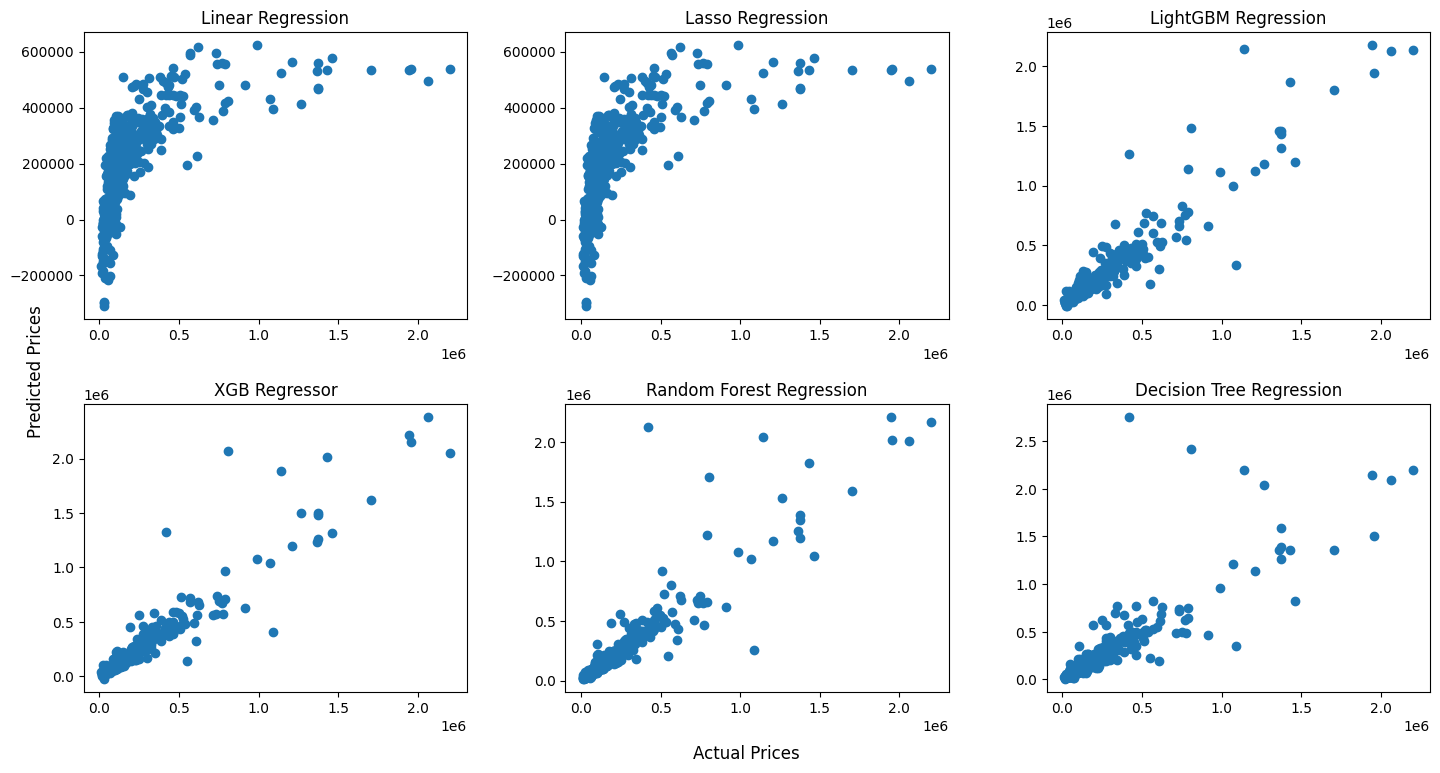

In [63]:
### Displaying the linearity between the predicted values and the actual values

figure, axis = plt.subplots(2, 3, figsize=(15, 8))

figure.tight_layout(pad=4.0)
figure.supxlabel('Actual Prices')
figure.supylabel('Predicted Prices')

axis[0, 0].scatter(y_test, linearReg_y_pred)
axis[0, 0].set_title("Linear Regression")

axis[0, 1].scatter(y_test, lassoReg_y_pred)
axis[0, 1].set_title("Lasso Regression")

axis[0, 2].scatter(y_test, lightGBM_y_pred)
axis[0, 2].set_title("LightGBM Regression")

axis[1, 0].scatter(y_test, XGB_y_pred)
axis[1, 0].set_title("XGB Regressor")

axis[1, 1].scatter(y_test, randomForest_y_pred)
axis[1, 1].set_title("Random Forest Regression")

axis[1, 2].scatter(y_test, decisionTree_y_pred)
axis[1, 2].set_title("Decision Tree Regression")

### The error and score of each algorithm

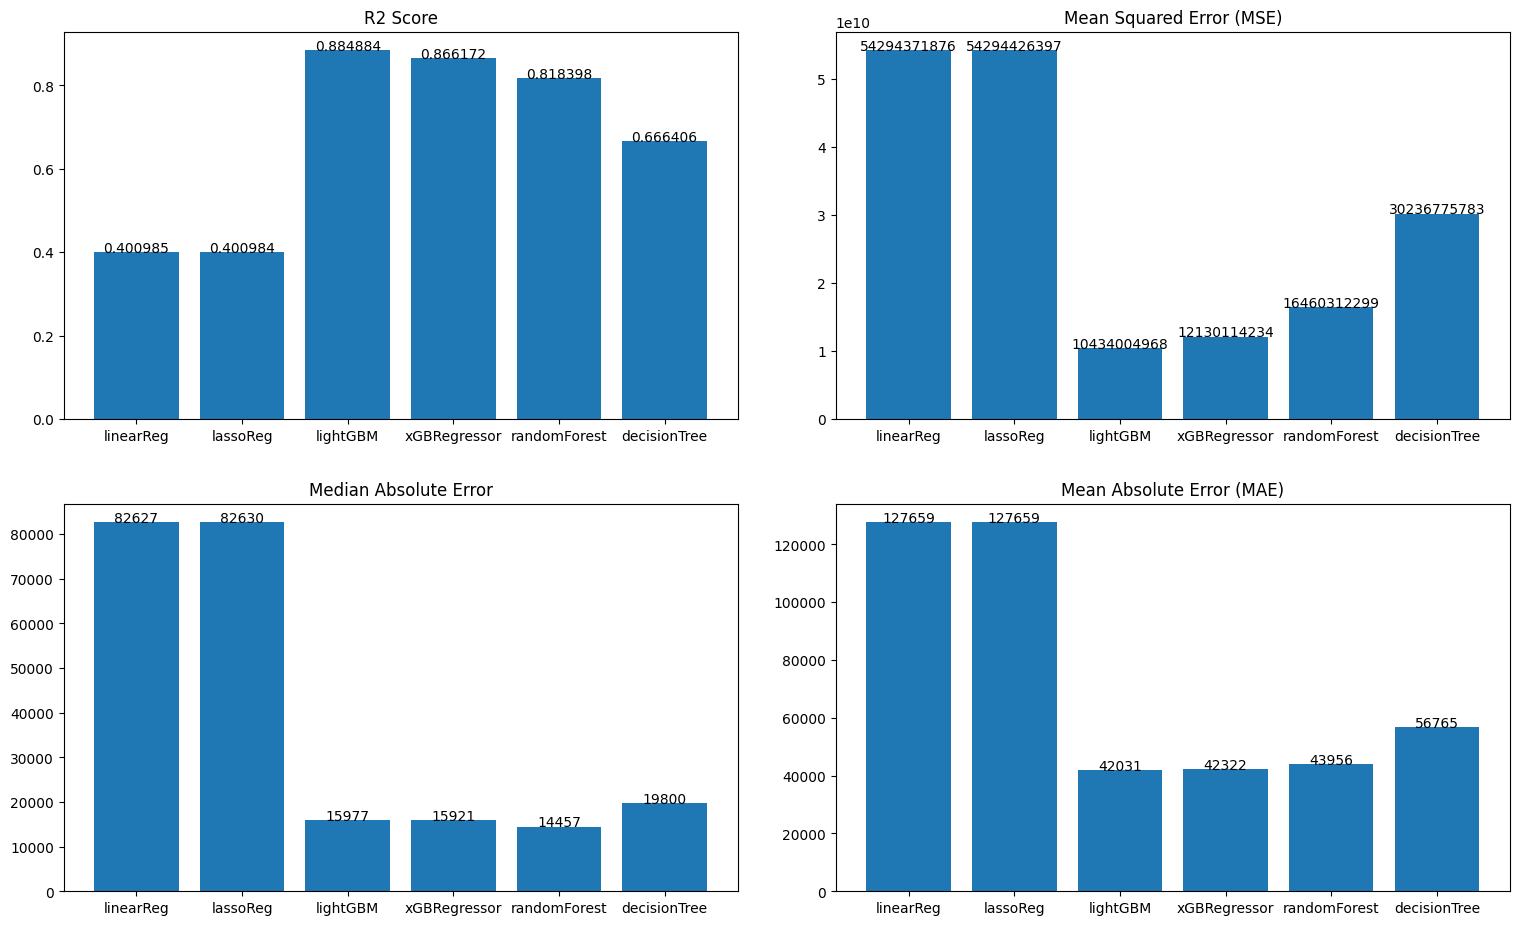

In [64]:
def addlabels(fig, x,y):
    for i in range(len(x)):
        fig.text(i,y[i],y[i], ha = 'center')

figure, axis = plt.subplots(2, 2, figsize=(16, 10))

figure.tight_layout(pad=4.0)

x_labels = ["linearReg", "lassoReg", "lightGBM", "xGBRegressor", "randomForest", "decisionTree"]

r2_y_values = [r2_score(y_test, linearReg_y_pred), r2_score(y_test, lassoReg_y_pred), r2_score(y_test, lightGBM_y_pred), r2_score(y_test, XGB_y_pred), r2_score(y_test, randomForest_y_pred), r2_score(y_test, decisionTree_y_pred)]
mse_y_valus = [mean_squared_error(y_test, linearReg_y_pred), mean_squared_error(y_test, lassoReg_y_pred), mean_squared_error(y_test, lightGBM_y_pred), mean_squared_error(y_test, XGB_y_pred), mean_squared_error(y_test, randomForest_y_pred), mean_squared_error(y_test, decisionTree_y_pred)]
medianse_y_values = [median_absolute_error(y_test, linearReg_y_pred), median_absolute_error(y_test, lassoReg_y_pred), median_absolute_error(y_test, lightGBM_y_pred), median_absolute_error(y_test, XGB_y_pred), median_absolute_error(y_test, randomForest_y_pred), median_absolute_error(y_test, decisionTree_y_pred)]
mae_y_values = [mean_absolute_error(y_test, linearReg_y_pred), mean_absolute_error(y_test, lassoReg_y_pred), mean_absolute_error(y_test, lightGBM_y_pred), mean_absolute_error(y_test, XGB_y_pred), mean_absolute_error(y_test, randomForest_y_pred), mean_absolute_error(y_test, decisionTree_y_pred)]

axis[0, 0].bar(x_labels, r2_y_values)
axis[0, 0].set_title("R2 Score")
addlabels(axis[0, 0], x_labels, list(map(lambda num: round(num, 6), r2_y_values)))

axis[0, 1].bar(x_labels, mse_y_valus)
axis[0, 1].set_title("Mean Squared Error (MSE)")
addlabels(axis[0, 1], x_labels, list(map(int, mse_y_valus)))

axis[1, 0].bar(x_labels, medianse_y_values)
axis[1, 0].set_title("Median Absolute Error")
addlabels(axis[1, 0], x_labels, list(map(int, medianse_y_values)))

axis[1, 1].bar(x_labels, mae_y_values)
axis[1, 1].set_title("Mean Absolute Error (MAE)")
addlabels(axis[1, 1], x_labels, list(map(int, mae_y_values)))

# Submission

### Loading the submission input data

In [65]:
submission_input_dataset = pd.read_csv('submission_x_values.csv').set_index('index')

pre_processed_submission_input_dataset = pre_processing(submission_input_dataset, True)
pre_processed_submission_input_dataset = columns_dropping(pre_processed_submission_input_dataset)
X_submission = pre_processed_submission_input_dataset.values


### Loading the validation data

In [66]:
validation_dataset = pd.read_csv('submission_y_values_real.csv').set_index('index').sort_index()
validation_dataset['Price']

index
1        85900.0
7       155200.0
11       26500.0
17      290500.0
26      146226.0
          ...   
4016    305900.0
4017     22100.0
4018     71800.0
4022     70500.0
4024    147500.0
Name: Price, Length: 1208, dtype: float64

### Price prediction and comparison

In [67]:
# Predict the price values using the LightGBM Regressor algorithm
y_pred_submission = lightGBMRegressor.predict(X_submission)
df = pd.DataFrame(y_pred_submission, columns=['Price'])

# Displaying the predicted price values
df['Price']

0        91452.488095
1       152861.115809
2        24734.753984
3       260319.247930
4       168171.800262
            ...      
1203    354691.657167
1204     22335.765213
1205     64375.204634
1206     -9284.360380
1207    236954.757420
Name: Price, Length: 1208, dtype: float64

In [68]:
print("R2 Score :", r2_score(validation_dataset['Price'], y_pred_submission))
print("Mean Squared Error (MSE) :", mean_squared_error(validation_dataset['Price'], y_pred_submission))
print("Median Absolute Error :", median_absolute_error(validation_dataset['Price'], y_pred_submission))
print("Mean Absolute Error (MAE) :", mean_absolute_error(validation_dataset['Price'], y_pred_submission))

R2 Score : 0.8236857371189166
Mean Squared Error (MSE) : 16052537010.977186
Median Absolute Error : 18339.420954810656
Mean Absolute Error (MAE) : 40652.00353492181


### Saving the submission file

In [69]:
submission_input_dataset[target_name] = y_pred_submission
submission_input_dataset.to_csv('submission_y_values_predicted.csv', index=False, encoding='UTF-8')

### Saving the model

In [70]:
lightGBMRegressor.booster_.save_model('LightGBR_Model.txt')